* Dataset : https://www.kaggle.com/datasets/larsen0966/student-performance-data-set
* Reference : https://dl.acm.org/doi/fullHtml/10.1145/3564982.3564990

# Predicting Students Performance Using Random Forest Algorithms

## Import Libraries

In [136]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score

## Load Dataset

In [137]:
# Charger les données à partir d'un fichier CSV
data = pd.read_csv('input/student-data.csv', sep=',')

# Initial Observation

In [138]:
data.head(4)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14


In [139]:
print(data.columns)

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')


## Correlation Analysis

In [140]:
# sns.set_theme(style="darkgrid")

# def plot_corr_map(plot_data, **kwargs):
#
#     _, ax = plt.subplots(figsize=(35, 35))
#     sns.heatmap(data=plot_data.corr(), ax=ax, **kwargs)
#     ax.set_title('Correlation Heatmap')

In [141]:
# params = {'annot': True, 'fmt': '.2g', 'cmap': 'YlGn',
#           'linewidths': 1, 'linecolor': 'black'}
#
# # We need to encode the string nominal columns to numbers
# encoded_df = data.iloc[:, :-1].copy()
# columns = encoded_df.select_dtypes(include=['object']).columns
# ordinal_encoder = OrdinalEncoder()
# encoded_df[columns] = ordinal_encoder.fit_transform(encoded_df[columns])
#
# plot_corr_map(encoded_df, **params)

# Data preprocessing

### Handling Unnecessary Columns

In [142]:
#Drop unwanted columns
data.drop(["school","romantic","Mjob","Fjob","reason","guardian","Dalc","Walc","activities","nursery","higher"],axis=1,inplace=True)

In [143]:
print(data.columns)

Index(['sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid',
       'internet', 'famrel', 'freetime', 'goout', 'health', 'absences', 'G1',
       'G2', 'G3'],
      dtype='object')


In [144]:
# Définir les classes basées sur les notes
def grade_to_class(grade):
    if grade <= 9:
        return 0  # Fail
    elif grade <= 11:
        return 1  # Sufficient
    elif grade <= 13:
        return 2  # Satisfactory
    elif grade <= 15:
        return 3  # Good
    else:
        return 4  # Excellent/Very Good

# Convertir les notes en classes
data['G3'] = data['G3'].apply(grade_to_class)

# Séparer les caractéristiques (X) de la variable cible (y)
X = data.drop('G3', axis=1)
y = data['G3']

# Convertir les variables catégorielles en variables indicatrices
X = pd.get_dummies(X)

In [145]:
X.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,...,Pstatus_A,Pstatus_T,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,internet_no,internet_yes
0,18,4,4,2,2,0,4,3,4,3,...,True,False,False,True,True,False,True,False,True,False
1,17,1,1,1,2,0,5,3,3,3,...,False,True,True,False,False,True,True,False,False,True
2,15,1,1,1,2,0,4,3,2,3,...,False,True,False,True,True,False,True,False,False,True
3,15,4,2,1,3,0,3,2,2,5,...,False,True,True,False,False,True,True,False,False,True
4,16,3,3,1,2,0,4,3,2,5,...,False,True,True,False,False,True,True,False,True,False


# Training

In [146]:
# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définir le modèle de classification RandomForest
model = RandomForestClassifier()

# Définir les hyperparamètres à optimiser
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Effectuer une recherche sur grille pour trouver la meilleure combinaison d'hyperparamètres
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Obtenir le meilleur modèle avec les hyperparamètres optimisés
best_model = grid_search.best_estimator_

# Faire des prédictions sur l'ensemble de test
y_pred = best_model.predict(X_test)

# Evaluation

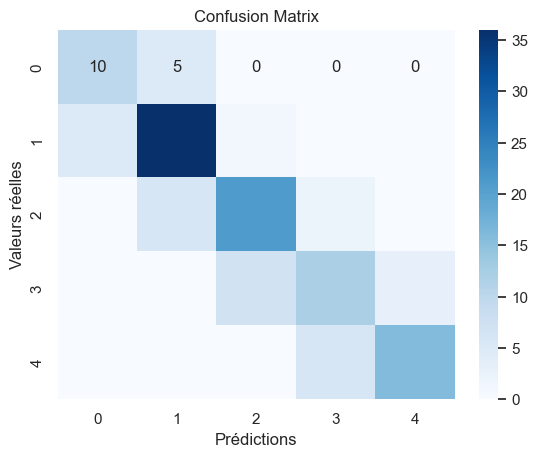

In [147]:
# Calculer la matrice de confusion
confusion = confusion_matrix(y_test, y_pred)
# print()
# print(confusion)

# Affichage de la matrice de confusion avec Seaborn
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='d')
plt.title("Confusion Matrix")
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()

In [148]:
# Prédire les classes
y_pred = best_model.predict(X_test)

# Calculer l'accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculer le f1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)

# Calculer le rappel (recall)
recall = recall_score(y_test, y_pred, average='weighted')
print("Rappel (Recall):", recall)

# Calculer l'AUC
y_prob = best_model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print("AUC:", auc)

# Afficher les meilleurs paramètres et le score de validation croisée
print("Best Hyperparameters:", grid_search.best_params_)
print("Cross-Validation Score:", grid_search.best_score_)

Accuracy: 0.7307692307692307
F1-score: 0.7286129874510253
Rappel (Recall): 0.7307692307692307
AUC: 0.9466789610138282
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Cross-Validation Score: 0.7550970873786407


## Saving the model

In [149]:
import json
import joblib

In [150]:
joblib.dump(best_model,"performance_prediction.joblib")

['performance_prediction.joblib']

In [151]:
# Après l'entraînement du modèle et la création de la liste des colonnes
columns = X.columns.tolist()  # X est votre DataFrame d'entraînement

# Enregistrer la liste des colonnes dans un fichier JSON
with open('columns.json', 'w') as f:
    json.dump(columns, f)